In [1]:
import math as maths

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import easygems.healpix as egh

In [2]:
sims = [
    # 'glm.n1280_CoMA9', # currently has no zarr store.
    'glm.n2560_RAL3p3',
    'glm.n1280_GAL9_nest',
    'SAmer_km4p4_RAL3P3.n1280_GAL9_nest',
    'Africa_km4p4_RAL3P3.n1280_GAL9_nest',
    'SEA_km4p4_RAL3P3.n1280_GAL9_nest',
    'SAmer_km4p4_CoMA9_TBv1.n1280_GAL9_nest',
    'Africa_km4p4_CoMA9_TBv1.n1280_GAL9_nest',
    'SEA_km4p4_CoMA9_TBv1.n1280_GAL9_nest',
    'CTC_km4p4_RAL3P3.n1280_GAL9_nest',
    'CTC_km4p4_CoMA9_TBv1.n1280_GAL9_nest'
]

In [13]:
class Item:
    def __init__(self, url):
        self.url = url

    def to_dataset(self):
        return xr.open_zarr(self.url)

class Catalog:
    """Really simple Catalog. Checks that args are valid/allowed."""
    def __init__(self, on_jasmin=False):
        if on_jasmin:
            self.url_tpl = 'http://hackathon-o.s3.jc.rl.ac.uk/sim-data/dev/v5/{sim}/um.{freq}.hp_z{zoom}.zarr'
        else:
            self.url_tpl = 'https://hackathon-o.s3-ext.jc.rl.ac.uk/sim-data/dev/v5/{sim}/um.{freq}.hp_z{zoom}.zarr'
        
    allowed_params = {
        'sim': sims,
        'freq': ['PT1H', 'PT3H'],
        'zoom': list(range(11)),
    }
    def __call__(self, **kwargs):
        if 'glm.n1280' in kwargs['sim']:
            if kwargs['zoom'] == 10:
                raise Exception('n1280 has no zoom=10')
            elif kwargs['zoom'] <= 8:
                print(f'WARNING: no data for zoom={kwargs["zoom"]}')
        else:
            if kwargs['zoom'] <= 9:
                print(f'WARNING: no data for zoom={kwargs["zoom"]}')
            
        for k, v in kwargs.items():
            if k not in self.allowed_params:
                raise Exception(f'Unknown param: {k}, must be one of {self.allowed_params.keys()}')
            if v not in self.allowed_params[k]:
                raise Exception(f'Unallowed param value: {v}, must be one of {self.allowed_params[k]}')
            
        return Item(self.url_tpl.format(**kwargs))

In [14]:
cat = Catalog()
# Show example URL
cat(sim='SAmer_km4p4_RAL3P3.n1280_GAL9_nest', freq='PT1H', zoom=10).url

'https://hackathon-o.s3-ext.jc.rl.ac.uk/sim-data/dev/v5/SAmer_km4p4_RAL3P3.n1280_GAL9_nest/um.PT1H.hp_z10.zarr'

In [15]:
# Open a dataset.
ds = cat(sim='SAmer_km4p4_RAL3P3.n1280_GAL9_nest', freq='PT1H', zoom=9).to_dataset()

In [16]:
tas = ds.tas.isel(time=0).compute()

In [17]:
tas

<xarray.DataArray 'tas' (cell: 1048576)> Size: 4MB
array([300.5017 , 300.46268, 300.48755, ..., 300.5583 , 300.57886,
       300.54474], dtype=float32)
Coordinates:
  * cell     (cell) int64 8MB 786432 786433 786434 ... 3145725 3145726 3145727
    crs      float64 8B nan
    time     datetime64[ns] 8B 2020-01-20
Attributes:
    STASH:          [1, 3, 236]
    UM_name:        air_temperature
    grid_mapping:   healpix_nested
    healpix_zoom:   9
    long_name:      air_temperature
    source:         Data from Met Office Unified Model
    standard_name:  air_temperature
    um_version:     13.5
    units:          K

<xarray.DataArray 'tas' (cell: 2097152)> Size: 8MB
array([300.51562, 300.48648, 300.51715, ..., 300.54324, 300.5463 ,
       300.53018], dtype=float32)
Coordinates:
  * cell     (cell) int64 17MB 3145728 3145729 3145730 ... 12582910 12582911
    crs      float64 8B nan
    time     datetime64[ns] 8B 2020-01-20
Attributes:
    STASH:          [1, 3, 236]
    UM_name:        air_temperature
    grid_mapping:   healpix_nested
    healpix_zoom:   10
    long_name:      air_temperature
    source:         Data from Met Office Unified Model
    standard_name:  air_temperature
    um_version:     13.5
    units:          K
0.37008094787597656


<Figure size 640x480 with 0 Axes>

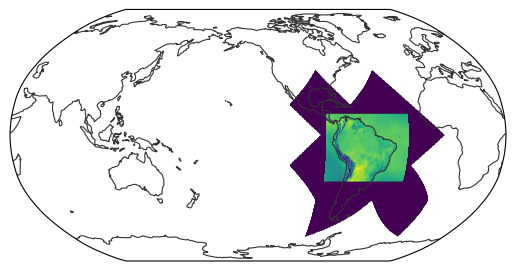

In [63]:
ds10 = cat(sim='SAmer_km4p4_RAL3P3.n1280_GAL9_nest', freq='PT1H', zoom=10).to_dataset()
tas10 = ds10.tas.isel(time=0).compute()
print(tas10)
ds_ones = xr.Dataset({'ones': (['cell'], np.ones_like(tas10))}, coords={'cell': ds10.cell}).assign_coords(crs=ds10.crs)
print((~np.isnan(tas10).values).sum() / tas10.size)
egh.healpix_show(ds_ones.ones)
egh.healpix_show(tas10)

<xarray.DataArray 'tas' (cell: 1048576)> Size: 4MB
dask.array<getitem, shape=(1048576,), dtype=float32, chunksize=(262144,), chunktype=numpy.ndarray>
Coordinates:
  * cell     (cell) int64 8MB 786432 786433 786434 ... 3145725 3145726 3145727
    crs      float64 8B ...
    time     datetime64[ns] 8B 2020-01-20
Attributes:
    STASH:          [1, 3, 236]
    UM_name:        air_temperature
    grid_mapping:   healpix_nested
    healpix_zoom:   9
    long_name:      air_temperature
    source:         Data from Met Office Unified Model
    standard_name:  air_temperature
    um_version:     13.5
    units:          K
0.1856374740600586


<Figure size 640x480 with 0 Axes>

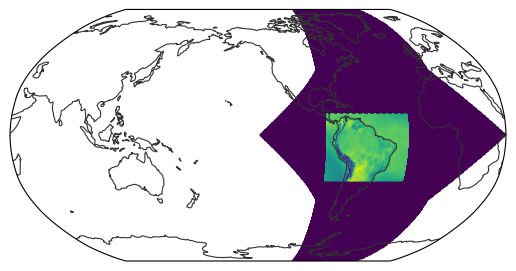

In [64]:
ds9 = cat(sim='SAmer_km4p4_RAL3P3.n1280_GAL9_nest', freq='PT1H', zoom=9).to_dataset()
# tas = ds.tas.isel(time=slice(20)).mean(dim='cell').compute()
tas9 = ds9.tas.isel(time=0)
ds_ones = xr.Dataset({'ones': (['cell'], np.ones_like(tas9))}, coords={'cell': ds9.cell}).assign_coords(crs=ds9.crs)
print(tas9)
print((~np.isnan(tas9).values).sum() / tas9.size)
egh.healpix_show(ds_ones.ones)
egh.healpix_show(tas9)

In [65]:
w9 = ds9.weights.compute()

In [69]:
w9.shape

(1048576,)

In [72]:
np.isnan(w9).sum()

<xarray.DataArray 'weights' ()> Size: 8B
array(524288)
Coordinates:
    crs      float64 8B nan

In [37]:
tas9.weighted(w9.fillna(0)).mean().compute()

<xarray.DataArray 'tas' ()> Size: 4B
array(298.19504, dtype=float32)
Coordinates:
    crs      float64 8B nan
    time     datetime64[ns] 8B 2020-01-20

In [38]:
tas10.mean().compute()

<xarray.DataArray 'tas' ()> Size: 4B
array(298.19492, dtype=float32)
Coordinates:
    crs      float64 8B nan
    time     datetime64[ns] 8B 2020-01-20

In [43]:
12 * 4**10

12582912

In [56]:
np.sort(ds9.cell)

array([ 786432,  786433,  786434, ..., 3145725, 3145726, 3145727])

In [55]:
12 * 4 **9

3145728

In [8]:
npix = 12 * 4**10
tasg = xr.DataArray(np.full(npix, np.nan, dtype=np.float32), coords={'cell': np.arange(npix)})

In [9]:
tasg[tas.cell] = tas

<Figure size 640x480 with 0 Axes>

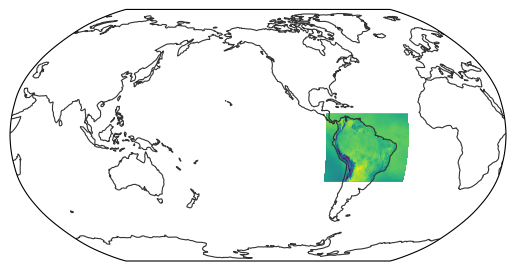

In [10]:
egh.healpix_show(tasg)

In [11]:
tasg9 = tasg.coarsen(cell=4).mean()

<Figure size 640x480 with 0 Axes>

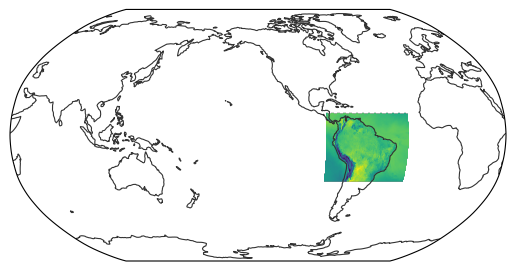

In [12]:
egh.healpix_show(tasg9)

In [13]:
def coarsen_weights(data, nan_weights=None):
    if nan_weights is None:
        new_weights = 1 - np.isnan(data.reshape(-1, 4)).sum(axis=-1) / 4
    else:
        new_weights = nan_weights.reshape(-1, 4).mean(axis=-1)
    return new_weights

In [14]:
tasg.mean().values

array(298.19492, dtype=float32)

In [15]:
w9 = coarsen_weights(tasg.values).astype(np.float32)

In [16]:
np.sum(tasg9.values * w9) / np.sum(w9)

np.float32(nan)

In [17]:
tasg9.mean().values

array(298.19308, dtype=float32)

In [18]:
tasg8 = tasg9.coarsen(cell=4).mean()

In [19]:
w8 = coarsen_weights(tasg9.values).astype(np.float32)

In [20]:
np.nansum(tasg8.values * w8) / np.sum(w8)

np.float32(298.1931)

In [21]:
tasg8.mean().values

array(298.1922, dtype=float32)

In [22]:
nf9 = np.nanmean(tasg.values.reshape(-1, 4), axis=-1)

/tmp/ipykernel_48239/1821476011.py:1: RuntimeWarning: Mean of empty slice
  nf9 = np.nanmean(tasg.values.reshape(-1, 4), axis=-1)


In [23]:
np.nansum(nf9 * w9) / w9.sum()

np.float32(298.195)

In [25]:
tasg9.weighted(xr.DataArray(w9, coords={'cell': tasg9.cell})).mean().values

array(298.19498, dtype=float32)

In [39]:
def nan_weight(arr, axis):
    # print(arr.shape)
    # print(axis)
    return ((~np.isnan(arr)).sum(axis=axis) / 4).astype(np.float32)

In [33]:
tasg.coarsen(cell=4).reduce(nan_weight)

(3145728, 4)
(1,)


<xarray.DataArray (cell: 3145728)> Size: 25MB
array([0, 0, 0, ..., 4, 4, 4])
Coordinates:
  * cell     (cell) float64 25MB 1.5 5.5 9.5 ... 1.258e+07 1.258e+07 1.258e+07

In [40]:
tasg9 = tasg.coarsen(cell=4).mean()
w9 = tasg.coarsen(cell=4).reduce(nan_weight)

In [41]:
tasg9.weighted(w9).mean()

<xarray.DataArray ()> Size: 4B
array(298.19498, dtype=float32)

In [42]:
tasg.mean()

<xarray.DataArray ()> Size: 4B
array(298.19492, dtype=float32)

In [8]:
ds9 = cat(sim='SAmer_km4p4_RAL3P3.n1280_GAL9_nest', freq='PT1H', zoom=9).to_dataset()

<Figure size 640x480 with 0 Axes>

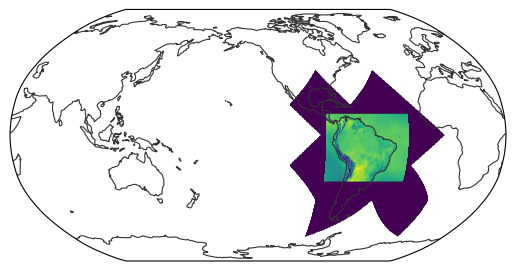

In [9]:
ds_ones = xr.Dataset({'ones': (['cell'], np.ones_like(tas))}, coords={'cell': ds.cell}).assign_coords(crs=ds.crs)
egh.healpix_show(ds_ones.ones)
egh.healpix_show(tas)

<Figure size 640x480 with 0 Axes>

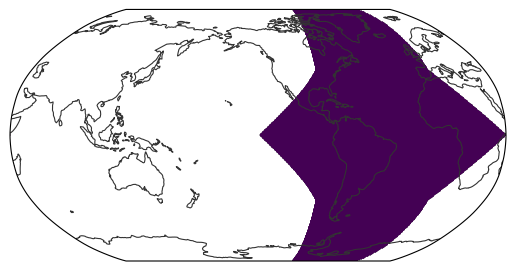

In [10]:
ds9 = cat(sim='SAmer_km4p4_RAL3P3.n1280_GAL9_nest', freq='PT1H', zoom=9).to_dataset()
ds9_ones = xr.Dataset({'ones': (['cell'], np.ones_like(ds9.tas.isel(time=0)))}, coords={'cell': ds9.cell}).assign_coords(crs=ds9.crs)
egh.healpix_show(ds9_ones.ones)

In [11]:
tas9 = tas.coarsen(cell=4).mean()
tas9.crs.attrs['healpix_nside'] = 2**9

<Figure size 640x480 with 0 Axes>

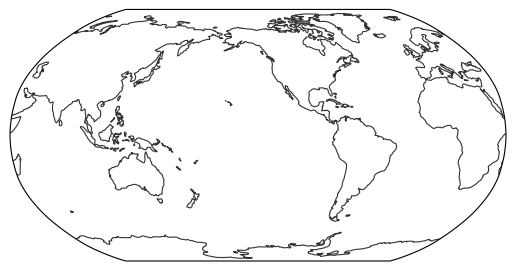

In [12]:
egh.healpix_show(tas9)

In [13]:
tas

<xarray.DataArray 'tas' (cell: 2097152)> Size: 8MB
array([300.51562, 300.48648, 300.51715, ..., 300.54324, 300.5463 ,
       300.53018], dtype=float32)
Coordinates:
  * cell     (cell) int64 17MB 3145728 3145729 3145730 ... 12582910 12582911
    crs      float64 8B nan
    time     datetime64[ns] 8B 2020-01-20
Attributes:
    STASH:          [1, 3, 236]
    UM_name:        air_temperature
    grid_mapping:   healpix_nested
    healpix_zoom:   10
    long_name:      air_temperature
    source:         Data from Met Office Unified Model
    standard_name:  air_temperature
    um_version:     13.5
    units:          K

In [14]:
tas9

<xarray.DataArray 'tas' (cell: 524288)> Size: 2MB
array([300.5017 , 300.46268, 300.48755, ..., 300.5583 , 300.57886,
       300.54474], dtype=float32)
Coordinates:
  * cell     (cell) float64 4MB 3.146e+06 3.146e+06 ... 1.258e+07 1.258e+07
    crs      float64 8B nan
    time     datetime64[ns] 8B 2020-01-20
Attributes:
    STASH:          [1, 3, 236]
    UM_name:        air_temperature
    grid_mapping:   healpix_nested
    healpix_zoom:   10
    long_name:      air_temperature
    source:         Data from Met Office Unified Model
    standard_name:  air_temperature
    um_version:     13.5
    units:          K

<Figure size 640x480 with 0 Axes>

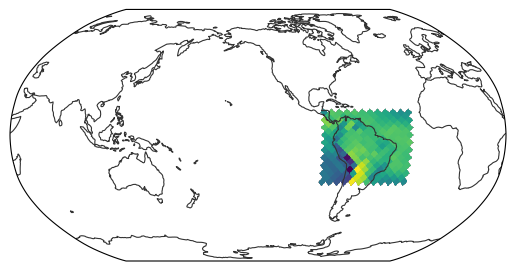

In [20]:
tasc = tasg.copy()
for i in range(6):
    tasc = tasc.coarsen(cell=4).mean()
egh.healpix_show(tasc)

In [35]:
tasg9.cell.values[ds9.cell.values]

array([ 3145729.5,  3145733.5,  3145737.5, ..., 12582901.5, 12582905.5,
       12582909.5])

In [43]:
npix = len(ds9.cell)
tas9 = xr.DataArray(np.full(npix, np.nan, dtype=np.float32), coords={'cell': ds9.cell})

In [48]:
tas9.values = tasg9.values[ds9.cell.values]

In [49]:
ds9c = xr.Dataset()
ds9c['tas'] = tas9
ds9c = ds9c.assign_coords(crs=ds9.crs)

In [50]:
ds9c.cell

<xarray.DataArray 'cell' (cell: 1048576)> Size: 8MB
array([ 786432,  786433,  786434, ..., 3145725, 3145726, 3145727])
Coordinates:
  * cell     (cell) int64 8MB 786432 786433 786434 ... 3145725 3145726 3145727
    crs      float64 8B ...

<Figure size 640x480 with 0 Axes>

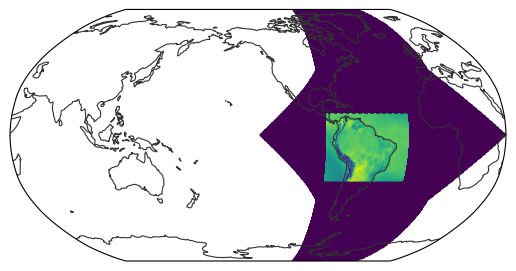

In [53]:
ds9c_ones = xr.Dataset({'ones': (['cell'], np.ones_like(ds9c.tas))}, coords={'cell': ds9c.cell}).assign_coords(crs=ds9c.crs)
egh.healpix_show(ds9c_ones.ones)
egh.healpix_show(ds9c.tas)

In [21]:
float(tas.mean().values)

298.1949157714844

In [165]:
(~np.isnan(tasg.values)).sum() / tasg.values.size

np.float64(0.06168015797932943)

In [166]:
(~np.isnan(tasg9.values)).sum() / tasg9.values.size

np.float64(0.06187915802001953)

In [167]:
np.nansum(tasg9.values * w) / w.sum()

np.float64(298.1950008436236)

In [168]:
np.nanmean(tasg.values)

np.float32(298.19492)

<Figure size 640x480 with 0 Axes>

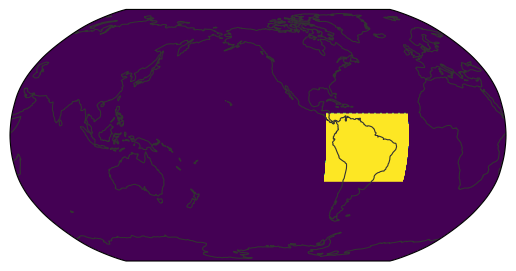

In [70]:
egh.healpix_show(w)

In [79]:
z = 10

In [80]:
a = np.arange(12 * 4**z)

In [81]:
import healpix as hp

In [82]:
lons, lats = hp.pix2ang(
    2**z, a, nest=True, lonlat=True,
)

In [83]:
lats

array([ 0.03730194,  0.0746039 ,  0.0746039 , ..., -0.0746039 ,
       -0.0746039 , -0.03730194])

In [84]:
m = (lats < 45) & (lats > -45) & (lons < 270) & (lons > 180)

In [85]:
d = (a**2).astype(float)

In [86]:
d[~m] = np.nan

In [87]:
m

array([False, False, False, ..., False, False, False])

In [88]:
da = xr.DataArray(d, coords={'cell': a})

In [89]:
#egh.healpix_show(da)

In [90]:
da.values[5] = np.nan

<Figure size 640x480 with 0 Axes>

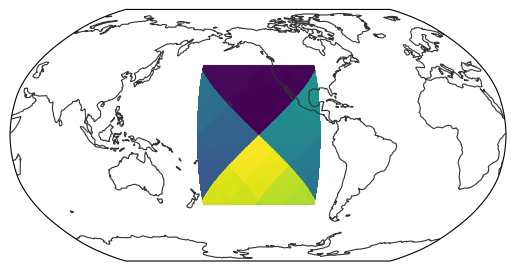

In [91]:
egh.healpix_show(da)

In [92]:
float(da.mean())

60390601503878.5

In [93]:
dac = da.coarsen(cell=4).mean()

<Figure size 640x480 with 0 Axes>

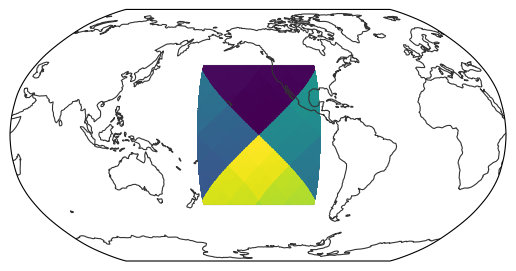

In [94]:

egh.healpix_show(dac)

In [95]:
float(dac.mean())

60383684908998.5

In [96]:
w = coarsen_weights(da.values)

In [97]:
float(np.nansum(dac.values * w) / w.sum())

60390601503878.33